# Plant Pathology 2021 FGVC8
## Description

Apples are one of the most important temperate fruit crops in the world. Foliar (leaf) diseases pose a major threat to the overall productivity and quality of apple orchards. The current process for disease diagnosis in apple orchards is based on manual scouting by humans, which is time-consuming and expensive.

Although computer vision-based models have shown promise for plant disease identification, there are some limitations that need to be addressed. Large variations in visual symptoms of a single disease across different apple cultivars, or new varieties that originated under cultivation, are major challenges for computer vision-based disease identification. These variations arise from differences in natural and image capturing environments, for example, leaf color and leaf morphology, the age of infected tissues, non-uniform image background, and different light illumination during imaging etc.

Plant Pathology 2021-FGVC8 challenge competition had a pilot dataset of 3,651 RGB images of foliar disease of apples. For Plant Pathology 2021-FGVC8, we have significantly increased the number of foliar disease images and added additional disease categories. This year’s dataset contains approximately 23,000 high-quality RGB images of apple foliar diseases, including a large expert-annotated disease dataset. This dataset reflects real field scenarios by representing non-homogeneous backgrounds of leaf images taken at different maturity stages and at different times of day under different focal camera settings.

## Specific Objectives
The main objective of the competition is to develop machine learning-based models to accurately classify a given leaf image from the test dataset to a particular disease category, and to identify an individual disease from multiple disease symptoms on a single leaf image.

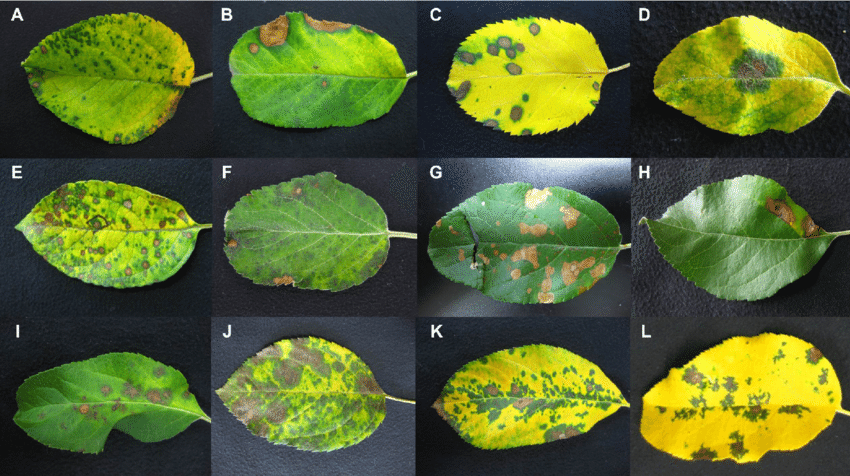

In [ ]:
#importing necessary libraries
import tensorflow as tf
from sklearn.preprocessing import MultiLabelBinarizer
from collections import defaultdict
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, MaxPooling2D, Conv2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121, EfficientNetB5, Xception
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#loading training data
train_df = pd.read_csv('../input/plant-pathology-2021-fgvc8/train.csv')
train_path = "../input/plant-pathology-2021-fgvc8/train_images"
train_df.head()

It can be seen that some pictures have several labels. I think this is a multi-label classification task

In [ ]:
train_df.info()

No empty values.

## Image samples

Let's look at an example picture

In [ ]:
img = plt.imread(train_path+"/"+train_df["image"][0])
img.shape

In [ ]:
plt.imshow(img)

## Visualization

Building a histogram of class labels

In [ ]:
train_df.groupby('labels').count().plot(kind='bar', title='Target class distribution', figsize=(20,10), grid=1)

In [ ]:
train_df["labels"].unique()

There are 12 classes in total. Many labels are complex. Let's look at an example of a picture from each label

In [ ]:
fig, ax = plt.subplots(3, 4, figsize=(20, 10))
for i, img in enumerate(train_df.groupby('labels').first().reset_index().values):
    ax[i//4][i%4].imshow(plt.imread(f"../input/plant-pathology-2021-fgvc8/train_images/{img[1]}"))
    ax[i//4][i%4].set_title(img[0])
    ax[i//4][i%4].axis('off')
fig.suptitle('Image Samples', fontsize=18); 

# Data Preprocessing

Now let's highlight the most basic labels for future convenience

In [ ]:
mlb = MultiLabelBinarizer().fit(train_df.labels.apply(lambda x : x.split()))
labels = pd.DataFrame(mlb.transform(train_df.labels.apply(lambda x : x.split())), columns = mlb.classes_)

labels = pd.concat([train_df['image'], labels], axis=1)
labels.head()

# Image Generator

In [ ]:
image_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=5,
    zoom_range=0.1,
    shear_range=0.05,
    horizontal_flip=True,
    validation_split=0.2
    
)
IMAGE = (224, 224)
BATCH_SIZE = 32

In [ ]:
train_generator = image_datagen.flow_from_dataframe(
    labels,
    directory='../input/resized-plant2021/img_sz_256',
    x_col="image",
    y_col=labels.columns.tolist()[1:],
    target_size=IMAGE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    subset="training",
    shuffle=True,
    seed=42,
    class_mode="raw"
)

In [ ]:
validation_generator = image_datagen.flow_from_dataframe(
    labels,
    directory='../input/resized-plant2021/img_sz_256',
    x_col="image",
    y_col=labels.columns.tolist()[1:],
    target_size=IMAGE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    subset="validation",
    shuffle=True,
    seed=42,
    class_mode="raw"
)

In [ ]:
example = next(train_generator)
print(example[0].shape)
plt.imshow(example[0][0,:,:,:])
plt.show()

# Model

In [ ]:
WEIGHTS_PATH = '../input/weights/efficientnetb5_notop.h5'
base_model = EfficientNetB5(weights=WEIGHTS_PATH,include_top=False, input_shape=(224,224,3))

x=base_model.output

x=GlobalAveragePooling2D()(x)

x=Dense(64,activation='relu')(x)
x=Dropout(0.3)(x)

x=Dense(32,activation='relu')(x)
x=Dropout(0.3)(x)

preds=Dense(6,activation='sigmoid')(x)

model=Model(inputs=base_model.input, outputs=preds)

In [ ]:
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"])

## Callbacks

In [ ]:
model_checkpoint = ModelCheckpoint(
    filepath="./appletree.h5", 
    monitor='val_loss', 
    save_best_only=True, 
    verbose=1,
    mode='min')

early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0,
    patience=10, 
    verbose=1, 
    restore_best_weights=True)

# Training

In [ ]:
history = model.fit(train_generator,
                validation_data=validation_generator,
                steps_per_epoch = train_generator.n // BATCH_SIZE,
                validation_steps = validation_generator.n // BATCH_SIZE,
                epochs=10,
                callbacks=[model_checkpoint, early_stopping])

In [ ]:
model.save('apple')

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

In [ ]:
test_df = pd.read_csv('../input/plant-pathology-2021-fgvc8/sample_submission.csv')
test_path = "../input/plant-pathology-2021-fgvc8/test_images"

In [ ]:
test_df.head()

In [ ]:
img = plt.imread(test_path+"/"+test_df["image"][0])
plt.imshow(img)

In [ ]:
img = plt.imread(test_path+"/"+test_df["image"][1])
plt.imshow(img)

In [ ]:
img = plt.imread(test_path+"/"+test_df["image"][2])
plt.imshow(img)

In [ ]:
image_test_datagen = ImageDataGenerator(
    rescale=1./255,
)

In [ ]:
test_generator = image_test_datagen.flow_from_dataframe(
    test_df,
    directory = test_path,
    x_col = "image",
    y_col = "labels",
    target_size = IMAGE,
    color_mode="rgb",
    batch_size=1,
    shuffle=False,
    seed=42,
    subset=None
)

In [ ]:
loaded_model = keras.models.load_model("apple")

In [ ]:
predicts = loaded_model.predict(test_generator)
predicts

In [ ]:
verdict = (predicts>0.40)
label = labels.columns.tolist()[1:]
verdict

In [ ]:
answer = []
for i in range(verdict.shape[0]):
    tmp = []
    for j, c in enumerate(label):
        if verdict[i, j]:
            tmp.append(c)
    answer.append(tmp)
    
answer = [' '.join(t) for t in answer]
answer

In [ ]:
test_df['labels'] = np.array(answer)

test_df

In [ ]:
test_df.to_csv('submission.csv', index=False)